<a href="https://colab.research.google.com/github/sun-fox/self-driving-car/blob/master/DRT_autonomous_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/rslim087a/track

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 39.95 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [ ]:
!ls track

driving_log.csv  IMG


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization
import random
import ntpath

In [ ]:
datadir = 'track'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'),names=columns)
pd.set_option('display.max_colwidth',None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_382.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_670.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_724.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_792.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\left_2018_07_16_17_11_43_860.jpg,C:\Users\Amer\Desktop\new_track\IMG\right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


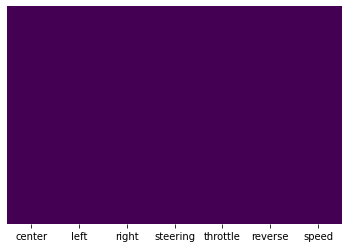

In [ ]:
import seaborn as sns
sns.heatmap(data.isnull(),yticklabels=False,cbar=False, cmap='viridis')

In [ ]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center']=data['center'].apply(path_leaf)
data['left']=data['left'].apply(path_leaf)
data['right']=data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


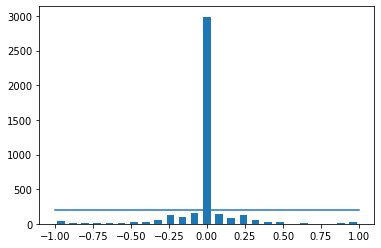

In [ ]:
num_bins = 25 
samples_per_bin = 200
hist, bins = np.histogram(data['steering'],num_bins)
center = ((bins[:-1] + bins[1:]))*0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
data['steering']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
4048    0.0
4049    0.0
4050    0.0
4051    0.0
4052    0.0
Name: steering, Length: 4053, dtype: float64

total data: 4053
removed: 2790
remaining: 1263


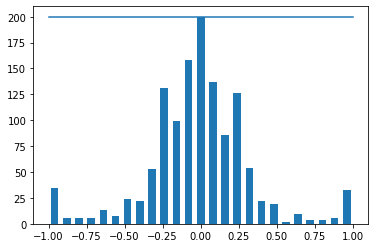

In [ ]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
  lst = []
  for i in range(len(data['steering'])):
    if(data['steering'][i]>=bins[j] and data['steering'][i]<bins[j+1]):
      lst.append(i)
  lst = shuffle(lst)
  lst = lst[samples_per_bin:]
  remove_list.extend(lst)

print('removed:',len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining:',len(data))

hist, _ = np.histogram(data['steering'],(num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [ ]:
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG',data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths,steerings,test_size=0.2,random_state=6)
print('Training Samples: {}\n Valid Samples: {}'.format(len(X_train),len(X_valid)))

Training Samples: 1010
 Valid Samples: 253


Text(0.5, 1.0, 'Validation set')

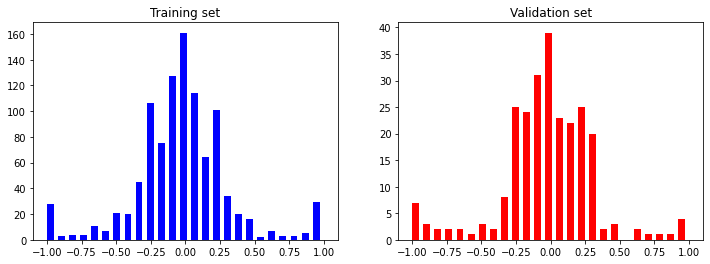

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img = img/255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

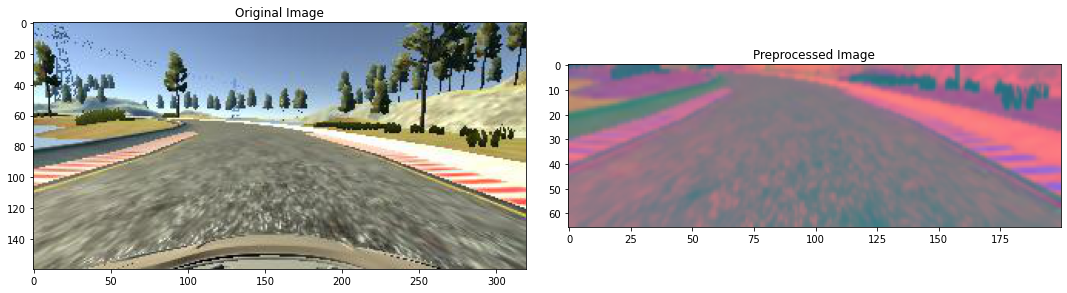

In [ ]:
image = image_paths[190]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [ ]:
# run this only once as it tampers the X_train and X_valid sets, if to run again run after re-initialization of train_test_split.
X_train = np.asarray(list(map(img_preprocess, X_train)))
X_valid = np.asarray(list(map(img_preprocess, X_valid)))

(1010, 66, 200, 3)


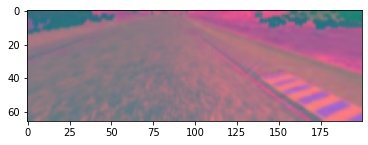

In [127]:
plt.imshow(X_train[random.randint(0,len(X_train)-1)])
plt.axis('on')
print(X_train.shape)

In [167]:
def nvidia_model():
  model = Sequential()
  model.add(Conv2D(24, kernel_size=(5, 5),strides=(2,2), input_shape=(66,200, 3), activation='elu'))
  model.add(Conv2D(36, kernel_size=(5, 5),strides=(2,1), activation='elu'))
  model.add(Conv2D(48, kernel_size=(5, 5), activation='elu'))
  model.add(Conv2D(64, 3, 3, activation='elu'))
  model.add(Conv2D(64, 3, 3, activation='elu'))
  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dropout(0.5))
  model.add(Dense(1))

  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer)
  return model

In [168]:
model = nvidia_model()
print(model.summary())

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_100 (Conv2D)          (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_101 (Conv2D)          (None, 14, 94, 36)        21636     
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 10, 90, 48)        43248     
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 3, 30, 64)         27712     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 1, 10, 64)         36928     
_________________________________________________________________
dropout_44 (Dropout)         (None, 1, 10, 64)         0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 640)             

In [170]:
history = model.fit(X_train, y_train,epochs=30,validation_data=(X_valid, y_valid),batch_size=100,verbose=1,shuffle = 1)

Epoch 1/30
11/11 [==============================] - 1s 47ms/step - loss: 0.5532 - val_loss: 0.1076
Epoch 2/30
11/11 [==============================] - 0s 24ms/step - loss: 0.2386 - val_loss: 0.1157
Epoch 3/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1606 - val_loss: 0.1063
Epoch 4/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1419 - val_loss: 0.1035
Epoch 5/30
11/11 [==============================] - 0s 25ms/step - loss: 0.1253 - val_loss: 0.0999
Epoch 6/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1206 - val_loss: 0.0932
Epoch 7/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1335 - val_loss: 0.0895
Epoch 8/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1139 - val_loss: 0.0865
Epoch 9/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1091 - val_loss: 0.0817
Epoch 10/30
11/11 [==============================] - 0s 24ms/step - loss: 0.1033 - val_loss: 0.0779
Epoch 11/

Text(0.5, 0, 'Epoch')

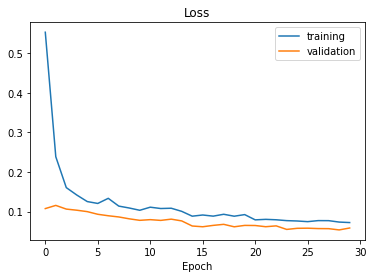

In [171]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [172]:
model.save('model.h5')

In [173]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>